# SQTE

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Gopal-Dahale/sqte/blob/main/4_sqte.ipynb)

## Setup

In [ ]:
# !pip install -q pennylane

In [1]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"

In [2]:
import jax

jax.devices()

[CpuDevice(id=0)]

In [3]:
# again, this only works on startup!

import jax

jax.config.update("jax_enable_x64", True)

In [4]:
# create sampler and estimator

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

backend_options = {
    "precision": "single",
    "max_parallel_threads": 12,
    "max_parallel_experiments": 0,
    "max_parallel_shots": 0,
    "fusion_enable": True,
    "fusion_threshold": 14,
    "fusion_max_qubit": 4,
    "matrix_product_state_max_bond_dimension": 256,
    "matrix_product_state_truncation_threshold": 1e-16,
    "mps_sample_measure_algorithm": "mps_apply_measure",
    "mps_parallel_threshold": 12,
    "mps_omp_threads": 12,
    "mps_lapack": False,
    "seed_simulator": 42,
}

aer_sim = AerSimulator(method="matrix_product_state", **backend_options)
aer_sim.set_max_qubits(200)

pm = generate_preset_pass_manager(
    backend=aer_sim, optimization_level=1, seed_transpiler=42
)

from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.primitives import SamplerV2 as Sampler

sampler = Sampler()
sampler._backend = aer_sim

estimator = Estimator()
estimator._backend = aer_sim

- magnetization operator: $\sum_i Z_i$
- mean spin correlation operator: $\sum_i Z_i Z_{i+1} / (n - 1)$.

In [5]:
from qiskit.quantum_info import SparsePauliOp


def tfim(n, J, h):
    ZZ_tuples = [("ZZ", [i, i + 1], J) for i in range(n - 1)]
    X_tuples = [("X", [i], h) for i in range(n)]

    H = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=n)
    return H


def aux_ham(n):
    # magnetization operator
    M = SparsePauliOp.from_sparse_list(
        [("Z", [i], 1.0) for i in range(0, n)], num_qubits=n
    )

    # mean spin correlation operator
    S = SparsePauliOp.from_sparse_list(
        [("ZZ", [i, i + 1], 1.0) for i in range(0, n - 1)], num_qubits=n
    ) / (n - 1)

    return M, S

## Exact

In [6]:
from time import time

import scipy as sc
from qiskit.quantum_info import Statevector


def exact_evolve(n, H, final_time, n_steps, aux_obs=None, verbose=False):
    start = time()
    initial_state = Statevector.from_label("0" * n)
    delta_t = final_time / n_steps
    times = np.linspace(delta_t, final_time, n_steps)  # dosent include initial state

    # We compute the exact evolution using the exp
    # find faster way to do this classically
    H_array = H.to_matrix()
    exact_evolution = [
        initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in times
    ]

    exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])

    if aux_obs is None:
        return exact_energy

    evs = []
    for ham in aux_obs:
        evs.append(np.real([sv.expectation_value(ham) for sv in exact_evolution]))
    evs = np.array(evs)
    end = time()
    if verbose:
        print(f"Duration for exact evolution: {end-start:.4f}")

    return np.vstack((exact_energy, evs))

## Trotter

In [7]:
def estimate_observables(ansatz, obs):
    pubs = [(ansatz, ham) for ham in obs]
    result = estimator.run(pubs).result()
    return np.array([res.data.evs for res in result])

In [8]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter


def trotter_evolve(n, H, final_time, n_steps, order=1, aux_obs=None, verbose=False):
    start = time()
    observables = []
    delta_t = final_time / n_steps

    # append initial state if different that |00....0>
    qc = QuantumCircuit(n)
    for i in range(n_steps):
        if verbose:
            print(f"Time step: {i}")

        qc.append(
            PauliEvolutionGate(H, delta_t, synthesis=SuzukiTrotter(order=order)),
            range(n),
        )

        # estimate observables
        isa_qc = pm.run(qc)
        observables.append(estimate_observables(isa_qc, [H] + aux_obs))

    observables = np.array(observables)
    end = time()
    if verbose:
        print(f"Duration for Trotter evolution: {end-start:.4f}")
    return observables

## SQTE

In [9]:
import jax


@jax.jit
def connected_elements_and_amplitudes_bool(bitstring, diag, sign, imag):
    """Find the connected element to computational basis state |X>."""
    bitstring_mask = bitstring == diag
    return bitstring_mask.astype(int), jnp.prod(
        (-1) ** (jnp.logical_and(bitstring, sign))
        * jnp.array(1j, dtype="complex64") ** (imag)
    )


batch_conn = jax.vmap(connected_elements_and_amplitudes_bool, (0, None, None, None))

In [10]:
def int_conversion_from_bts_array(bit_array: np.ndarray):
    """Convert a bit array to an integer representation."""
    n_qubits = len(bit_array)
    bitarray_asint = 0.0
    for i in range(n_qubits):
        bitarray_asint = bitarray_asint + bit_array[i] * 2 ** (n_qubits - 1 - i)

    return bitarray_asint.astype("longlong")  # type: ignore


bin_to_int = jax.jit(jax.vmap(int_conversion_from_bts_array, 0, 0))

In [11]:
from scipy.sparse import coo_matrix


def project_hamiltonian(samples, hamiltonian):
    d, n = samples.shape
    operator = coo_matrix((d, d), dtype="complex128")

    for i, pauli in enumerate(hamiltonian.paulis):
        coeff = hamiltonian.coeffs[i]
        row_ids = np.arange(d)

        # qubit wise representation
        diag = np.logical_not(pauli.x)[::-1]
        sign = pauli.z[::-1]
        imag = np.logical_and(pauli.x, pauli.z)[::-1]

        # convert to int
        decimal_values = bin_to_int(samples)

        samples_conn, amplitudes = batch_conn(samples, diag, sign, imag)

        decimal_conn = bin_to_int(samples_conn)

        conn_mask = np.isin(
            decimal_conn, decimal_values, assume_unique=True, kind="sort"
        )

        # keep samples that are represented both in the original samples
        # and connected elements
        amplitudes = amplitudes[conn_mask]
        decimal_conn = decimal_conn[conn_mask]
        row_ids = row_ids[conn_mask]

        # Get column indices of non-zero matrix elements
        col_ids = np.searchsorted(decimal_values, decimal_conn)

        operator += coeff * coo_matrix((amplitudes, (row_ids, col_ids)), (d, d))

    return operator

In [12]:
import jax.numpy as jnp

to_int_list = lambda bs: list(map(int, list(bs)))


def sampled_projector(ansatz, obs, sampler_args):
    pubs = (ansatz,)
    sampler._seed = sampler_args.get("seed", 42)
    job = sampler.run(pubs, shots=sampler_args.get("shots", 1000))

    samples = job.result()[0].data.meas.get_bitstrings()
    samples = jnp.array([to_int_list(i) for i in samples])

    # add the basis states needed to express the initial state
    samples = jnp.r_[samples, [jnp.zeros(n, dtype=int)]]

    # Need to sort the binary rows and remove duplicates
    # for large integers, maybe try numpy lexsort
    decimal_values = bin_to_int(samples)

    _, indices = jnp.unique(decimal_values, return_index=True)
    samples = samples[indices]

    obs_proj = [project_hamiltonian(samples, ham) for ham in obs]
    return obs_proj, samples

In [24]:
def sampled_evolve(
    n, H, final_time, n_steps, order=1, aux_obs=None, sampler_args={}, verbose=False
):
    start = time()
    observables_sqte = []
    delta_t = final_time / n_steps
    times = np.linspace(
        delta_t, final_time, num_timesteps
    )  # dosent include initial state

    # append initial state if different that |00....0>
    qc = QuantumCircuit(n)
    for i in range(n_steps):
        if verbose:
            print(f"Time step: {i}")

        qc.append(
            PauliEvolutionGate(H, delta_t, synthesis=SuzukiTrotter(order=order)),
            range(n),
        )

        # perform sampling and project observables
        isa_qc = pm.run(qc)
        isa_qc.measure_all()
        obs_proj, samples = sampled_projector(isa_qc, [H] + aux_obs, sampler_args)

        if verbose:
            print(f"Number of bitstrings: {samples.shape[0]}")

        # project initial state
        # currently hardcoded and only works with |00 .. 0>
        psi0_proj = jnp.zeros(samples.shape[0])
        psi0_proj = psi0_proj.at[0].set(1.0)

        # normalize if needed
        norm = jnp.linalg.norm(psi0_proj)
        if not jnp.allclose(norm, 1.0):
            psi0_proj /= norm

        # Time evolution in projected space
        H_proj = obs_proj[0]

        print(H_proj)
        print(H_proj.shape)
        
        U_proj = jax.scipy.linalg.expm(-1j * times[i] * H_proj.todense())
        psi_proj = U_proj @ psi0_proj

        # estimate observables classically
        evs = []
        for ham in obs_proj:
            evs.append(jnp.vdot(psi_proj, ham @ psi_proj))

        evs = jnp.real(jnp.array(evs))
        observables_sqte.append(evs)
        break

    end = time()
    if verbose:
        print(f"Duration for sampled evolution: {end-start:.4f}")

    return np.array(observables_sqte)

## Time evolution Expt

In [25]:
# row_ids = np.arange(3)
# int_array_rows = np.array([1, 5, 7])
# int_array_conn = np.array([7, 3, 1])
# mask = np.isin(int_array_conn, int_array_rows, assume_unique=True, kind="sort")
# int_array_conn = int_array_conn[mask]
# row_ids = row_ids[mask]
# col_array = np.searchsorted(int_array_rows, int_array_conn)

In [26]:
# mask, int_array_conn, row_ids, col_array

In [27]:
# H_mat = SparsePauliOp(["XYZ"]).to_matrix().imag.astype(int)

In [28]:
# decimal_values = int_array_rows
# idxs = np.ix_(decimal_values, decimal_values)
# H_proj = H_mat[idxs]
# H_proj.shape

In [29]:
# H_proj

In [30]:
import numpy as np

## configuration

# hamiltonian
n = 4
J = 0.2
h = 2.2

# time evolution
final_time = 10.0
num_timesteps = 30

# sampling 
n_shots = 20
seed = 42

In [31]:
H = tfim(n, J, h)
M, S = aux_ham(n)

if n <= 10:
    exact_energy, exact_magnetization, exact_correlation = exact_evolve(
        n, H, final_time, num_timesteps, [M, S], 1
    )

Duration for exact evolution: 0.0737


In [32]:
estimator.options.run_options = {
    'seed_simulator': seed,
    'shots': n_shots
}

# observables = trotter_evolve(n, H, final_time, num_timesteps, 2, [M, S], 1)

In [33]:
sampler_args = {"seed": seed, "shots": n_shots}
observables_sqte = sampled_evolve(
    n, H, final_time, num_timesteps, 2, [M, S], sampler_args, 1
)

Time step: 0
Number of bitstrings: 8
<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 24 stored elements and shape (8, 8)>
  Coords	Values
  (0, 0)	(0.6000000000000001+0j)
  (0, 1)	(2.2+0j)
  (0, 2)	(2.2+0j)
  (1, 0)	(2.2+0j)
  (1, 1)	(0.2+0j)
  (1, 3)	(2.2+0j)
  (2, 0)	(2.2+0j)
  (2, 2)	(-0.2+0j)
  (2, 5)	(2.2+0j)
  (3, 1)	(2.2+0j)
  (3, 3)	(-0.6000000000000001+0j)
  (3, 4)	(2.2+0j)
  (4, 3)	(2.2+0j)
  (4, 4)	(0.2+0j)
  (4, 7)	(2.2+0j)
  (5, 2)	(2.2+0j)
  (5, 5)	(-0.6000000000000001+0j)
  (5, 6)	(2.2+0j)
  (6, 5)	(2.2+0j)
  (6, 6)	(-0.2+0j)
  (6, 7)	(2.2+0j)
  (7, 4)	(2.2+0j)
  (7, 6)	(2.2+0j)
  (7, 7)	(0.6000000000000001+0j)
(8, 8)
Duration for sampled evolution: 1.0392


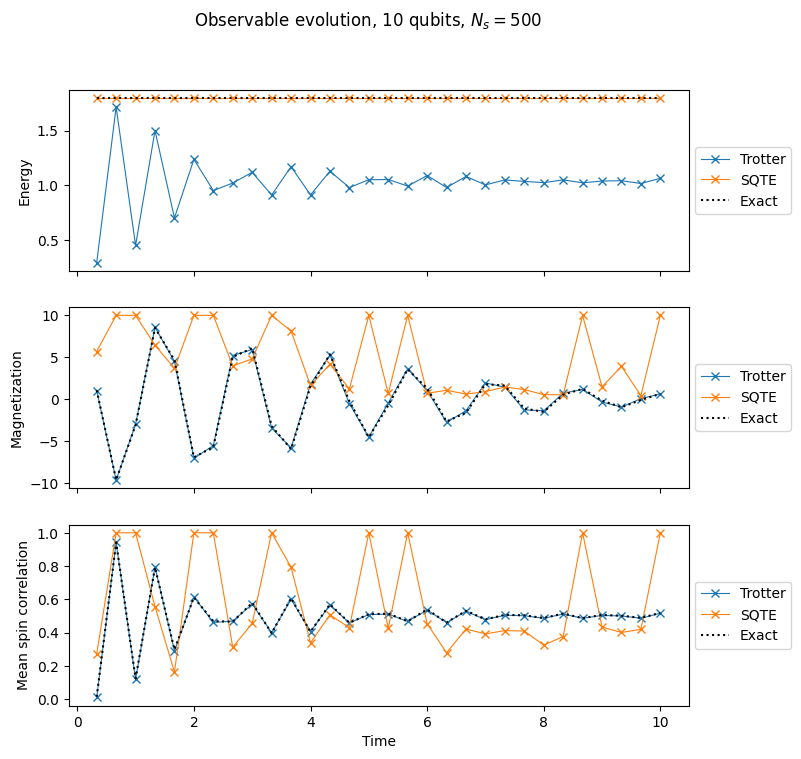

In [52]:
import matplotlib.pyplot as plt

dt = final_time / num_timesteps
times = np.linspace(dt, final_time, num_timesteps)  # dosent include initial state

fig, axes = plt.subplots(3, sharex=True, figsize=(8, 8))
axes[0].plot(times, observables[:, 0], label="Trotter", marker="x", ls="-", lw=0.8)
axes[0].plot(times, observables_sqte[:, 0], label="SQTE", marker="x", ls="-", lw=0.8)


axes[1].plot(times, observables[:, 1], label="Trotter", marker="x", ls="-", lw=0.8)
axes[1].plot(times, observables_sqte[:, 1], label="SQTE", marker="x", ls="-", lw=0.8)

axes[2].plot(times, observables[:, 2], label="Trotter", marker="x", ls="-", lw=0.8)
axes[2].plot(times, observables_sqte[:, 2], label="SQTE", marker="x", ls="-", lw=0.8)

if n <= 10:
    try:
        axes[0].plot(times, exact_energy, c="k", ls=":", label="Exact")
        axes[1].plot(times, exact_magnetization, c="k", ls=":", label="Exact")
        axes[2].plot(times, exact_correlation, c="k", ls=":", label="Exact")
    except:
        pass

for ax in axes:
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")


fig.suptitle(f"Observable evolution, {n} qubits, $ N_s = {n_shots}$")
plt.show()

## Expval with system size

In [53]:
times

array([ 0.33333333,  0.66666667,  1.        ,  1.33333333,  1.66666667,
        2.        ,  2.33333333,  2.66666667,  3.        ,  3.33333333,
        3.66666667,  4.        ,  4.33333333,  4.66666667,  5.        ,
        5.33333333,  5.66666667,  6.        ,  6.33333333,  6.66666667,
        7.        ,  7.33333333,  7.66666667,  8.        ,  8.33333333,
        8.66666667,  9.        ,  9.33333333,  9.66666667, 10.        ])

In [60]:
n_qubits = [2, 4, 6, 8, 10]
final_time = 1.0
num_timesteps = 1
n_trials = 20
n_shots = 20000

print(f"Evolving for {final_time:.4f} time")

results = {
    'exact': [],
    'trotter': [],
    'sqte': []
}

for n in n_qubits:
    print(f"Number of qubits: {n}")

    start = time()
    H = tfim(n, J, h)
    M, S = aux_ham(n)

    # Exact
    if n <= 10:
        exact_res = exact_evolve(n, H, final_time, num_timesteps, [M, S])
        results['exact'].append(exact_res)

    # Trotter
    trotter_res = []
    for trial in range(n_trials):
        estimator.options.run_options = {
            'seed_simulator': trial,
            'shots': n_shots
        }
        observables = trotter_evolve(n, H, final_time, num_timesteps, 2, [M, S])
        trotter_res.append(observables)
    trotter_res = np.array(trotter_res)
    results['trotter'].append(trotter_res)

    # SQTE
    sqte_res = []
    for trial in range(n_trials):
        sampler_args = {"seed": trial, "shots": n_shots}
        observables_sqte = sampled_evolve(
            n, H, final_time, num_timesteps, 2, [M, S], sampler_args
        )
        sqte_res.append(observables_sqte)
    sqte_res = np.array(sqte_res)
    results['sqte'].append(sqte_res)

    end = time()
    print(f"Duration: {end-start:.4f}")

for key, val in results.items():
    results[key] = np.array(val)

Evolving for 1.0000 time
Number of qubits: 2
Duration: 7.1973
Number of qubits: 4
Duration: 11.8561
Number of qubits: 6
Duration: 15.8553
Number of qubits: 8
Duration: 22.6272
Number of qubits: 10
Duration: 47.9936


In [61]:
for key, val in results.items():
    print(key, val.shape)

exact (5, 3, 1)
trotter (5, 20, 1, 3)
sqte (5, 20, 1, 3)


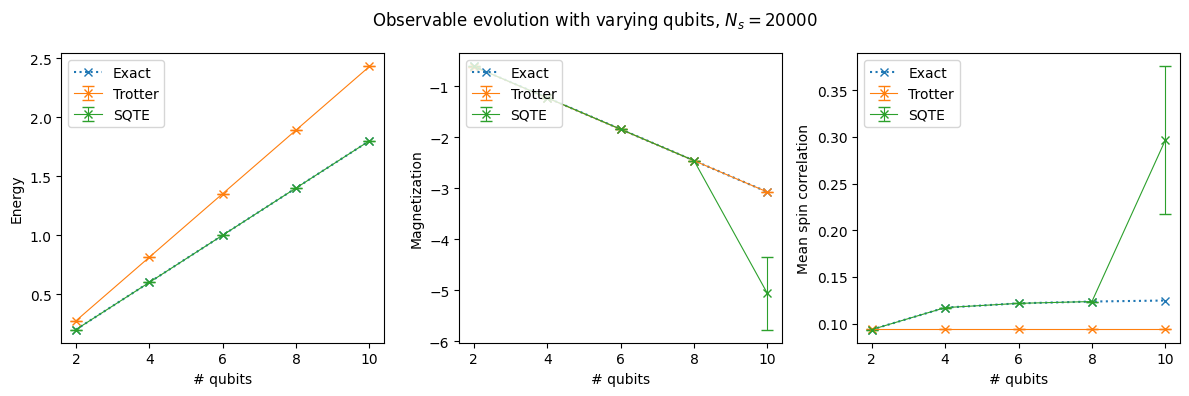

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

if n <= 10:
    for i in range(3):
        axes[i].plot(n_qubits, results['exact'][:, i, 0], marker='x', ls=':', label='Exact')

for i in range(3):

    # Trotter
    res = results['trotter'][:, :, 0, :]
    avg = res.mean(axis=1)
    error = res.std(axis=1)
    axes[i].errorbar(
        n_qubits,
        avg[:, i],
        error[:, i],
        marker="x",
        ls="-", 
        lw=0.8,
        label="Trotter",
        capsize=4,
    )

    # SQTE
    res = results['sqte'][:, :, 0, :]
    avg = res.mean(axis=1)
    error = res.std(axis=1)
    axes[i].errorbar(
        n_qubits,
        avg[:, i],
        error[:, i],
        marker="x",
        ls="-", 
        lw=0.8,
        label="SQTE",
        capsize=4,
    )


titles = ["Energy", "Magnetization", "Mean spin correlation"]
for ax, title in zip(axes, titles):
    ax.set_xticks(n_qubits)
    ax.legend(loc="upper left")
    ax.set_xlabel("# qubits")
    ax.set_ylabel(title)


fig.suptitle(f"Observable evolution with varying qubits, $ N_s = {sampler_args.get('shots')}$")
plt.tight_layout()
plt.show()